In [1]:
import numpy as np
import random
from collections import OrderedDict, defaultdict
from collections import Counter
from scipy.stats import norm
import pandas as pd
from copy import deepcopy
import time
import json
import math

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pickle
import seaborn as sns
import networkx as nx

In [2]:
### Helper methods, Lapo's stuff
def node_to_idxs(node, N):
    return [node // N, node % N]


def unzip(l):
    return list(zip(*l))

def normal_marginals(side_len, locality):
    rv = norm(loc=0, scale=locality)
    x = np.linspace(-1, 1, side_len * 2 + 1)
    p = rv.pdf(x)
    peak = side_len
    cols = list(range(side_len))
    marginals = []
    for col in cols:
        start = peak - col
        stop = start + side_len
        subset = np.array(p[start:stop])
        subset /= subset.sum()
        marginals.append(subset)
    for subset in marginals:
        assert np.isclose(subset.sum(), 1.0)
    return marginals

def gen_gauss_weights(marginals):
    weights = []
    for i, col in enumerate(marginals):
        for j, row in enumerate(marginals):
            X, Y = np.meshgrid(row, col)
            w = X * Y
            w[i][j] = 0
            w /= w.sum()
            weights.append(w.flatten())
    return np.array(weights)

def gen_unif_weights(N):
    w = np.ones((N ** 2, N ** 2))
    return w / N ** 2

def show_weights(weights, N):
    i = 0
    while i < len(weights):
        w = weights[i].reshape(N, N)
        plt.imshow(w)
        plt.show()
        i += np.random.randint(N ** 2 // 3)


def show_3d_weights(weights, N):
    fig = plt.figure()
    ax = fig.gca(projection="3d")

    # Make data.
    X = np.arange(0, N)
    Y = np.arange(0, N)
    X, Y = np.meshgrid(X, Y)
    Z = weights.reshape(N, N)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)

    # Customize the z axis.
    # a x.set_zlim(0, .001)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

In [3]:
### Helper methods, Karl's and Csenge's stuff


def init_network_edges(N,av_k,sample_type):
    """
    Adds edges to the initialised empty network.

    Parameters:
        :N:                   Number of nodes in the network.
        :av_k:                Average degree.
        :sample_type:         The type of sampling method we want to use.

    Returns:
        None (adds edges to empty network).
    """

    for node in range(N):
        new_edges = np.random.normal(loc=av_k, scale=1.0)
        if new_edges < 0:
            new_edges = 0
        #if sample_type == "local": #check if this is needed
        network.add_edges(node, int(new_edges))

def let_them_go(firing_nodes , N): 
    """
    Adds activity to nodes that are neighbors of firing nodes.

    Parameters:
        :firing_nodes:            Set of nodes that reached the treshold.

    Returns:
        New activity state and nodes that fired (we need for fitness).
    """
    
    activity_state = np.zeros(N)
    for x in firing_nodes:
        nodes_that_receive = list(network.adjL.get(x))
        activity_state[nodes_that_receive] += 20
    return activity_state

def network_fitness(N, network):
    """
    Calculates a fitness score for a network.

    Parameters:
        :network:          Network to calculate score for.
        
    Returns:
        Fitness score.
    """

    firing_nodes = list(range(N))
    max_iters = 1000
    iters = 0
    while len(firing_nodes) > 0 and iters < max_iters:
        print("fired")
        new_activity_state = let_them_go(firing_nodes, N)
        activity_state = new_activity_state
        firing_nodes = np.where(activity_state >= th)[0]
        iters += 1
        
    return (1)


In [4]:
class Network:
    def __init__(self, N, opts, backup=False):
        self.N = N
        self.adjM = np.zeros((N ** 2, N ** 2))
        self.adjL = defaultdict(set)
        self.nodes = np.arange(N ** 2)
        self.is_backup = backup
        self.opts = opts

        if opts["distr"] == "gauss":
            self.distr = opts["distr"]
            self.locality = opts["locality"]
            marginals = normal_marginals(self.N, self.locality)
            self.weights = gen_gauss_weights(marginals)

        elif opts["distr"] == "unif":
            self.distr = opts["distr"]
            self.weights = gen_unif_weights(self.N)
        else:
            raise RuntimeError("Distribution not implemented: " + opts["distr"])

        if backup == False:
            self.backup = Network(N, opts, backup=True)

    def add_edges(self, node, num_samples):
        num_samples = min(num_samples, self.N - 1 - len(self.backup.adjL[node]))
        samples = np.random.choice(
            self.nodes, p=self.weights[node], replace=False, size=num_samples
        )
        for sample in samples:
            self.weights[node][sample] = 0
            self.adjM[node][sample] = 1
            self.adjL[node].add(sample)

        self.weights[node] /= self.weights[node].sum()

        return samples

    def undo(self):
        self.adjM = np.copy(self.backup.adjM)
        self.adjL = deepcopy(self.backup.adjL)
        self.weights = np.copy(self.backup.weights)

    def commit(self):
        self.backup.adjM = np.copy(self.adjM)
        self.backup.adjL = deepcopy(self.adjL)
        self.backup.weights = np.copy(self.weights)

    def show_adj(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.adjM)
        plt.show()

    def serialize(self):
        opts = deepcopy(self.opts)
        opts["N"] = self.N
        info = [json.dumps(opts)+"\n"]
        timestr = time.strftime("%Y-%m-%d_%H%M%S")
        name = timestr + "_" + "_".join(
            [name + "_" + str(val).replace(".", "") for name, val in self.opts.items()]
        )
        name += ".edgelist"
        data = ["{} {}\n".format(node,neigh) for node,neighs in self.adjL.items() for neigh in neighs]
        with open(name,'w') as f:
            f.writelines(info + data)
        return name
    
    def show_grid(self, size, labels):
        """
        Visualizes whole network grid using networkx.

        Params:
            :int size:      The size of the nodes labels.
            :bool labels:   Whether the nodes are or are not labelled.

        Returns:
            None. (prints a figure)
        """

        # Reformat edges for networkx friendly format.
        edges = []
        for i in self.adjL.keys():
            if (len(self.adjL[i]) > 0):
                for j in self.adjL[i]:
                    edges.append((i,j))

        # Create node mapping:
        mapping = {}
        for i in range(self.N):
            for j in range(self.N):

                # For each node ID, find coords and set empty adjlist.
                mapping[(self.N * i) + j] = (i,j)

        # Fix mapping to play nicer with networkx 
        pos = {x:(mapping[x][1], self.N - mapping[x][0])
              for x in mapping.keys()}

        # Display figure
        g = nx.DiGraph()
        g.add_nodes_from(mapping.keys())
        g.add_edges_from(edges)
        plt.figure(figsize=(16, 16))
        nx.draw(g, with_labels=labels, pos=pos, node_size=size)
        plt.show()
    
    

In [26]:
### Sample run

#Parameters
L = 20 #side of the grid
N = L*L #number of nodes
av_k = 5 #average degree in the beginning
init_edges = N*av_k # number of edges in the initial network
sample_type = "local"
locality = 1
th = 100 # minimum number of signals that initiate firing of node

In [27]:
#Init network
opts = {"distr": "gauss", "locality": 0.2}
network = Network(L,opts)
init_network_edges(N,av_k,sample_type)

### Component 1 of fitness function

In [28]:
#fitness as balanced edge activity

def let_them_go_v1(firing_nodes , N, nedge): 
    
    activity_state = np.zeros(N)
    
    for x in firing_nodes:
        nodes_that_receive = network.adjL.get(x,[])
        if len(nodes_that_receive) > 0 :
            activity_state[list(nodes_that_receive)] += 20
            for i in nodes_that_receive:
                nedge.append((x,i))
            
    return activity_state, nedge

def network_fitness_comp1(N, network):

    nedge= []
    
    firing_nodes = list(range(N))
    max_iters = 1000
    iters = 0
    while len(firing_nodes) > 0 and iters < max_iters:
        #print("fired")
        new_activity_state, new_nedge = let_them_go_v1(firing_nodes, N, nedge)
        activity_state = new_activity_state
        nedge = new_nedge
        firing_nodes = np.where(activity_state >= th)[0]
        iters += 1
    
    count_edges = Counter(map(tuple, nedge))
    freqs = list(count_edges.values())
    freqs.sort(reverse = True)
    #freqs_count = Counter(freqs)
    
    num_edges = sum(map(len, network.adjL.values()))
    T = num_edges*0.75
    summ = 0
    idx = 0
    while summ <= T:
        summ = summ + freqs[idx] 
        idx += 1
        
    fitness_comp1 = (idx/num_edges)*100
        
    return fitness_comp1, freqs

In [29]:
fitness, freqs = network_fitness_comp1(N,network)

In [30]:
fitness #the more the better

34.13812464907355

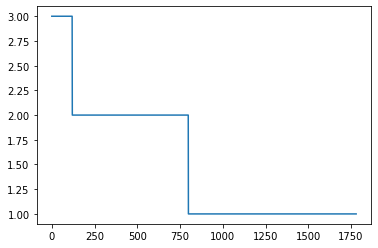

In [31]:
plt.plot(freqs)

### Component 2 of fitness function

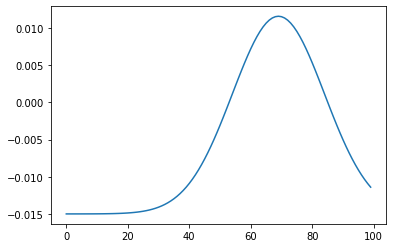

In [32]:
def gauss(x, mean, scale):
    return (1 / (scale * math.sqrt(2 * math.pi)) * (math.e ** -(0.5 * (x - mean)**2 / scale**2))) -0.015
y = np.linspace(1, 100, 100) 
x = gauss(y,70,15)
plt.plot(x)

In [33]:
def let_them_go_v2(firing_nodes , N): 
    
    activity_state = np.zeros(N)
    
    for x in firing_nodes:
        nodes_that_receive = network.adjL.get(x,[])
        if len(nodes_that_receive) > 0 :
            activity_state[list(nodes_that_receive)] += 20
        
    return activity_state

def network_fitness_comp2(N, network):
    
    fitn2 = []
    
    firing_nodes = list(range(N))
    max_iters = 1000
    iters = 0
    while len(firing_nodes) > 0 and iters < max_iters:
        #print("fired")
        new_activity_state = let_them_go_v2(firing_nodes, N)
        activity_state = new_activity_state
        firing_nodes = np.where(activity_state >= th)[0]
        iters += 1
        prop_node = len(firing_nodes)/N
        f = gauss((prop_node*100),70,15)
        fitn2.append(f)
        
    
    #averaging iterations
    ave_fitn = sum(fitn2) / (iters-1) #first loop everyone always fires
    
    fitness_2 = ave_fitn*1000
    
    return fitness_2

In [34]:
v2_fitness = network_fitness_comp2(N,network)

In [35]:
v2_fitness

-19.088956210746495